In [1]:
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt
import sklearn
from sklearn import pipeline  ,ensemble 
from sklearn.pipeline import Pipeline 
from sklearn import impute
from sklearn import compose
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix,roc_auc_score
from sklearn import set_config
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import Normalizer,PowerTransformer,QuantileTransformer, RobustScaler,StandardScaler,LabelEncoder, OneHotEncoder,OrdinalEncoder
from sklearn.tree          import DecisionTreeClassifier
from sklearn.linear_model  import LogisticRegression    
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
# from catboost              import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
set_config(display='diagram') # Useful for display the pipeline
print("Pandas  ", pd.__version__)
print("Sklearn ", sklearn.__version__) # Try to use 0.24



Pandas   1.2.4
Sklearn  0.24.2


In [4]:
data = pd.read_csv('./data/data_5secondWindow .csv')

In [5]:
data.head()

,id,time,activityrecognition#0,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.game_rotation_vector#mean,android.sensor.game_rotation_vector#min,...,sound#mean,sound#min,sound#max,sound#std,speed#mean,speed#min,speed#max,speed#std,target,user
0,16170,78.0,NaN,100.0,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,Luca
1,15871,145.0,NaN,100.0,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,...,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,0.628595,Car,Luca
2,16811,150.0,NaN,100.0,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,Luca
3,15831,105.0,NaN,77.0,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,...,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,0.628595,Car,Luca
4,876,77.0,NaN,100.0,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,...,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,NaN,Car,andrea


In [6]:
data.columns

Index(['id', 'time', 'activityrecognition#0', 'activityrecognition#1',
       'android.sensor.accelerometer#mean', 'android.sensor.accelerometer#min',
       'android.sensor.accelerometer#max', 'android.sensor.accelerometer#std',
       'android.sensor.game_rotation_vector#mean',
       'android.sensor.game_rotation_vector#min',
       'android.sensor.game_rotation_vector#max',
       'android.sensor.game_rotation_vector#std',
       'android.sensor.gravity#mean', 'android.sensor.gravity#min',
       'android.sensor.gravity#max', 'android.sensor.gravity#std',
       'android.sensor.gyroscope#mean', 'android.sensor.gyroscope#min',
       'android.sensor.gyroscope#max', 'android.sensor.gyroscope#std',
       'android.sensor.gyroscope_uncalibrated#mean',
       'android.sensor.gyroscope_uncalibrated#min',
       'android.sensor.gyroscope_uncalibrated#max',
       'android.sensor.gyroscope_uncalibrated#std',
       'android.sensor.light#mean', 'android.sensor.light#min',
       'android.se

In [7]:
def change_name(df):
    column_names=[]
    for i in df.columns:
        k=i.replace('.','_').replace("#",'_')
        df.rename(columns = {i:k}, inplace = True)
    return df
data=change_name(data)

In [8]:
data.user.unique()

array(['Luca', 'andrea', 'Federica', 'michelangelo', 'Damiano', 'Claudio',
       'Vincenzo', 'Serena', 'Pierpaolo', 'IvanHeibi', 'AndreaCarpineti',
       'Elena', 'Riccardo'], dtype=object)

In [9]:
data=data.drop(['id','time','activityrecognition_0'],axis=1)


In [10]:
# subscratct some user for test data 
df=data.copy()


In [11]:
df

,activityrecognition_1,android_sensor_accelerometer_mean,android_sensor_accelerometer_min,android_sensor_accelerometer_max,android_sensor_accelerometer_std,android_sensor_game_rotation_vector_mean,android_sensor_game_rotation_vector_min,android_sensor_game_rotation_vector_max,android_sensor_game_rotation_vector_std,android_sensor_gravity_mean,...,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std,target,user
0,100.0,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,0.029526,0.000119,9.806650,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,Luca
1,100.0,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,0.999946,0.000030,9.806624,...,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,0.628595,Car,Luca
2,100.0,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,0.665218,0.000004,9.806650,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,Luca
3,77.0,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,0.998661,0.003451,9.806638,...,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,0.628595,Car,Luca
4,100.0,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,0.672664,0.064792,9.806650,...,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,NaN,Car,andrea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,100.0,10.066610,4.564648,13.414389,3.373972,0.986319,0.974523,0.992084,0.007186,9.806650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Walking,IvanHeibi
5889,10.0,9.964271,8.768007,11.454213,0.665529,0.648602,0.648343,0.648974,0.000331,9.806650,...,NaN,NaN,NaN,NaN,31.960054,31.960054,31.960054,NaN,Train,Pierpaolo
5890,100.0,9.812893,9.772881,9.862587,0.017633,0.024392,0.024081,0.024696,0.000211,9.806650,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,Luca
5891,100.0,9.831144,9.807347,9.874450,0.013485,0.481212,0.481209,0.481216,0.000002,9.806621,...,NaN,NaN,NaN,NaN,1.090415,1.090415,1.090415,NaN,Still,Damiano


In [ ]:
user_train=['Luca', 'andrea', 'Federica', 'michelangelo', 'Damiano', 'Claudio',
       'Vincenzo', 'Serena',  'Riccardo']
user_test=['Pierpaolo', 'IvanHeibi', 'AndreaCarpineti','Elena',]

In [12]:
# create test data from some user 
user1=df[df['user']=='Pierpaolo']
user2=df[df['user']=='IvanHeibi']
user3=df[df['user']=='AndreaCarpineti']
user4=df[df['user']=='Elena']
users=[user1,user2,user3,user4]
df_test=pd.concat(users)

In [13]:
df_test

,activityrecognition_1,android_sensor_accelerometer_mean,android_sensor_accelerometer_min,android_sensor_accelerometer_max,android_sensor_accelerometer_std,android_sensor_game_rotation_vector_mean,android_sensor_game_rotation_vector_min,android_sensor_game_rotation_vector_max,android_sensor_game_rotation_vector_std,android_sensor_gravity_mean,...,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std,target,user
33,5.0,11.068949,9.764513,14.028126,1.283204,0.943836,0.936799,0.956021,0.010595,9.806651,...,77.064227,77.064227,77.064227,4.549349,1.191050,1.191050,1.191050,NaN,Walking,Pierpaolo
54,75.0,9.263056,8.712177,9.963264,0.361961,0.894102,0.894102,0.894102,0.002254,9.806650,...,74.178611,74.178611,74.178611,0.149748,0.000000,0.000000,0.000000,NaN,Bus,Pierpaolo
102,5.0,9.075213,9.012243,9.187340,0.070605,0.907671,0.905519,0.909333,0.001954,9.806651,...,6.020600,6.020600,6.020600,0.000000,0.000000,0.000000,0.000000,0.0,Walking,Pierpaolo
121,100.0,9.061146,8.246220,9.563967,0.451773,0.997597,0.997312,0.998010,0.000276,9.806651,...,72.559600,72.559600,72.559600,NaN,7.800006,7.800006,7.800006,NaN,Bus,Pierpaolo
172,100.0,10.335784,3.332163,17.743662,4.272022,0.991409,0.988798,0.994020,0.003693,9.806653,...,73.702289,73.702289,73.702289,NaN,1.250000,1.250000,1.250000,NaN,Walking,Pierpaolo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,8.0,10.482803,9.876226,11.574040,0.451683,NaN,NaN,NaN,NaN,9.806650,...,73.526555,73.526555,73.526555,0.417732,NaN,NaN,NaN,NaN,Train,Elena
5680,8.0,10.526549,9.810258,10.833432,0.208212,NaN,NaN,NaN,NaN,9.806650,...,70.312179,70.312179,70.312179,2.721671,NaN,NaN,NaN,NaN,Train,Elena
5686,8.0,10.604814,10.507165,10.717623,0.059674,NaN,NaN,NaN,NaN,9.806650,...,50.343918,50.343918,50.343918,0.417732,NaN,NaN,NaN,NaN,Train,Elena
5693,8.0,10.535159,9.784737,11.174831,0.353959,NaN,NaN,NaN,NaN,9.806651,...,67.043650,67.043650,67.043650,0.843263,NaN,NaN,NaN,NaN,Train,Elena


In [14]:
df_train = df.merge(df_test, how='left', indicator=True)
df_train = df_train[df_train['_merge'] == 'left_only']


In [15]:
df_train=df_train.drop('_merge',axis=1)


In [16]:
df_train


,activityrecognition_1,android_sensor_accelerometer_mean,android_sensor_accelerometer_min,android_sensor_accelerometer_max,android_sensor_accelerometer_std,android_sensor_game_rotation_vector_mean,android_sensor_game_rotation_vector_min,android_sensor_game_rotation_vector_max,android_sensor_game_rotation_vector_std,android_sensor_gravity_mean,...,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std,target,user
0,100.0,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,0.029526,0.000119,9.806650,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,Luca
1,100.0,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,0.999946,0.000030,9.806624,...,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,0.628595,Car,Luca
2,100.0,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,0.665218,0.000004,9.806650,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,Luca
3,77.0,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,0.998661,0.003451,9.806638,...,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,0.628595,Car,Luca
4,100.0,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,0.672664,0.064792,9.806650,...,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,NaN,Car,andrea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886,69.0,10.139576,10.010278,10.275756,0.080109,0.992914,0.992832,0.993090,0.000089,9.806650,...,89.744465,89.744465,89.744465,0.005501,NaN,NaN,NaN,NaN,Train,andrea
5887,100.0,9.608833,9.218854,10.113405,0.253208,0.595680,0.595680,0.595680,0.004038,9.806649,...,82.684818,82.684818,82.684818,1.472114,NaN,NaN,NaN,NaN,Train,michelangelo
5890,100.0,9.812893,9.772881,9.862587,0.017633,0.024392,0.024081,0.024696,0.000211,9.806650,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,Luca
5891,100.0,9.831144,9.807347,9.874450,0.013485,0.481212,0.481209,0.481216,0.000002,9.806621,...,NaN,NaN,NaN,NaN,1.090415,1.090415,1.090415,NaN,Still,Damiano


In [17]:
X=df_train.drop(['target','user','android_sensor_proximity_std'],axis=1)
y=df_train.target
num_features=X.columns


In [18]:
y

0         Still
1           Car
2         Still
3           Car
4           Car
         ...   
5886      Train
5887      Train
5890      Still
5891      Still
5892    Walking
Name: target, Length: 4985, dtype: object

In [ ]:
X

,activityrecognition_1,android_sensor_accelerometer_mean,android_sensor_accelerometer_min,android_sensor_accelerometer_max,android_sensor_accelerometer_std,android_sensor_game_rotation_vector_mean,android_sensor_game_rotation_vector_min,android_sensor_game_rotation_vector_max,android_sensor_game_rotation_vector_std,android_sensor_gravity_mean,...,android_sensor_step_counter_max,android_sensor_step_counter_std,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std
0,100.0,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,0.029526,0.000119,9.806650,...,28966.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
1,100.0,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,0.999946,0.000030,9.806624,...,NaN,NaN,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,0.628595
2,100.0,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,0.665218,0.000004,9.806650,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
3,77.0,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,0.998661,0.003451,9.806638,...,NaN,NaN,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,0.628595
4,100.0,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,0.672664,0.064792,9.806650,...,NaN,NaN,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886,69.0,10.139576,10.010278,10.275756,0.080109,0.992914,0.992832,0.993090,0.000089,9.806650,...,NaN,NaN,89.744465,89.744465,89.744465,0.005501,NaN,NaN,NaN,NaN
5887,100.0,9.608833,9.218854,10.113405,0.253208,0.595680,0.595680,0.595680,0.004038,9.806649,...,NaN,NaN,82.684818,82.684818,82.684818,1.472114,NaN,NaN,NaN,NaN
5890,100.0,9.812893,9.772881,9.862587,0.017633,0.024392,0.024081,0.024696,0.000211,9.806650,...,28966.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
5891,100.0,9.831144,9.807347,9.874450,0.013485,0.481212,0.481209,0.481216,0.000002,9.806621,...,6803.0,NaN,NaN,NaN,NaN,NaN,1.090415,1.090415,1.090415,NaN


In [22]:
from sklearn import  impute
im=impute.SimpleImputer(strategy='median', fill_value='missing')
X_im = pd.DataFrame(im.fit_transform(X))
X_im.columns=X.columns


In [23]:
def pca_func(X,type_):
    im=impute.SimpleImputer(strategy='median', fill_value='missing')
    if type_=='test':
        X_test = pd.DataFrame(im.fit_transform(X))
        X_test.columns=X.columns
        X_scaled = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
        X_pca = pca.transform(X_scaled)
        component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
        X_pca_test = pd.DataFrame(X_pca, columns=component_names)
        return X_pca_test
    else:
        X_train = pd.DataFrame(im.fit_transform(X))
        X_train.columns=X.columns
        X_scaled = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
        X_pca = pca.fit_transform(X_scaled)
        component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
        X_pca_train = pd.DataFrame(X_pca, columns=component_names)
        return X_pca_train

In [24]:
# d=df_train.drop(['target','user'],axis=1)
# t=pca_func(d,'test')

In [25]:
from sklearn.decomposition import PCA

X_scaled = (X_im - X_im.mean(axis=0)) / X_im.std(axis=0)
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64
0,-3.657719,-8.545003,4.060534,-2.183993,0.718969,-1.826472,0.808061,-1.582919,0.961045,-0.724039,...,-0.003256,0.000946,0.003289,-0.000127,-2.761023e-04,-0.000814,0.001200,-0.000013,-0.000005,8.801781e-07
1,-0.100666,-0.680470,-2.730236,1.989589,-0.326490,-1.728638,-0.062268,-0.181358,0.524085,2.415515,...,-0.006996,-0.000146,-0.016058,0.000886,5.500429e-04,0.003271,-0.002464,0.000562,-0.000038,-1.050247e-06
2,-1.834031,-2.026419,-1.092548,0.152194,0.639845,1.023512,-0.189165,1.907628,-1.741809,-1.476412,...,-0.003118,0.001386,-0.001250,0.001932,-3.503569e-03,0.003806,-0.003034,0.000341,0.000018,4.621574e-07
3,-0.274514,-0.387578,-2.591860,1.940254,-0.388866,-2.040632,0.274782,-0.958238,0.987381,2.615469,...,-0.014212,0.003612,-0.015022,0.000214,-7.758801e-05,0.003257,-0.003086,0.000491,-0.000029,1.015720e-06
4,0.892169,-1.224257,2.818314,1.129851,0.321895,0.033402,-0.227439,-0.928726,-0.905495,-0.388189,...,-0.028367,-0.007053,0.000294,0.001447,-4.470884e-03,0.000910,0.000854,-0.000963,0.000041,2.322901e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4980,-1.159736,0.875129,-2.151201,0.491824,-0.506615,-1.448134,-0.423798,0.237924,0.451513,-1.053389,...,-0.002904,0.010111,0.001662,0.000592,-1.002235e-03,-0.000585,-0.000363,0.000054,-0.000006,1.284265e-06
4981,-1.469012,2.770867,3.344875,-0.968529,-2.380528,0.824037,-1.878161,3.378341,1.617576,-0.594579,...,0.004079,0.000447,0.000368,0.001975,-4.913413e-04,0.000305,-0.001372,-0.000051,0.000003,-9.516065e-07
4982,-3.656899,-8.554398,4.071211,-2.192725,0.719605,-1.816834,0.806316,-1.575839,0.962749,-0.725487,...,-0.003173,0.000171,0.003221,-0.000092,-5.648681e-07,-0.000333,0.000682,0.000035,-0.000005,8.532519e-07
4983,-2.362360,0.627042,3.012096,-0.253811,1.183766,1.689474,-0.424602,-0.360178,-2.289084,-2.899311,...,-0.001318,0.000021,-0.000744,0.002166,-4.317733e-04,0.000843,0.000498,-0.000084,0.000011,-1.473632e-06


In [49]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

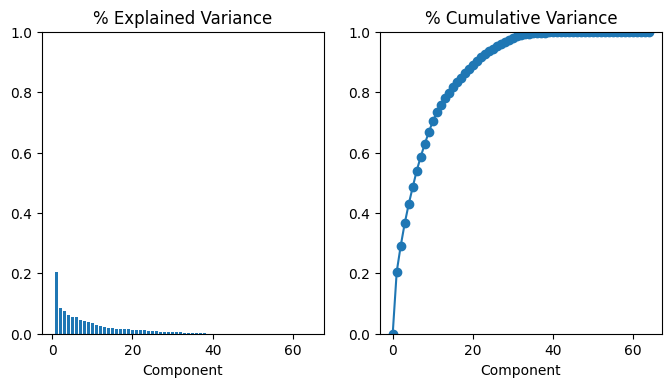

In [50]:

plot_variance(pca)

In [90]:
X_=X_pca[column]
print(X_.shape)
print(y.shape)

(4985, 20)
(4985,)


In [91]:
classifier_models = {
"DecisionTreeClassifier": DecisionTreeClassifier(),
'KNeighborsClassifier':KNeighborsClassifier(6),
'LogisticRegression':LogisticRegression(),
"RandomForestClassifier":ensemble.RandomForestClassifier(),
"AdaBoostClassifier":ensemble.AdaBoostClassifier(),
"GradientBoostingClassifier":ensemble.GradientBoostingClassifier(),
"XGBClassifier":XGBClassifier(),
"LGBMClassifier":LGBMClassifier(),
# "CatBoostClassifier":CatBoostClassifier(),

}


In [92]:

X_train, X_test, y_train, y_test = train_test_split(X_, y,test_size=0.2,stratify =y,random_state=10 )
results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [],'Time': []})
for model_name, model in classifier_models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    total_time = time.time() - start_time
    valid_pred = model.predict(X_test)
    results = results.append({"Model":    model_name,
                              "Accuracy": accuracy_score(y_test, valid_pred)*100,
                              "Bal Acc.": balanced_accuracy_score(y_test, valid_pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

[15:06:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Accuracy,Bal Acc.,Time
1,LGBMClassifier,97.091274,96.873810,13.317026
2,XGBClassifier,96.489468,96.320690,33.880648
3,RandomForestClassifier,96.088265,95.972176,2.206895
4,KNeighborsClassifier,95.185557,95.067678,0.008198
5,GradientBoostingClassifier,94.583751,94.602682,24.128400
6,DecisionTreeClassifier,89.969910,89.990385,0.150130
7,AdaBoostClassifier,72.016048,72.952393,1.588017
8,LogisticRegression,70.010030,71.349858,0.777344


In [ ]:
df_test

,activityrecognition_1,android_sensor_accelerometer_mean,android_sensor_accelerometer_min,android_sensor_accelerometer_max,android_sensor_accelerometer_std,android_sensor_game_rotation_vector_mean,android_sensor_game_rotation_vector_min,android_sensor_game_rotation_vector_max,android_sensor_game_rotation_vector_std,android_sensor_gravity_mean,...,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std,target,user
33,5.0,11.068949,9.764513,14.028126,1.283204,0.943836,0.936799,0.956021,0.010595,9.806651,...,77.064227,77.064227,77.064227,4.549349,1.191050,1.191050,1.191050,NaN,Walking,Pierpaolo
54,75.0,9.263056,8.712177,9.963264,0.361961,0.894102,0.894102,0.894102,0.002254,9.806650,...,74.178611,74.178611,74.178611,0.149748,0.000000,0.000000,0.000000,NaN,Bus,Pierpaolo
102,5.0,9.075213,9.012243,9.187340,0.070605,0.907671,0.905519,0.909333,0.001954,9.806651,...,6.020600,6.020600,6.020600,0.000000,0.000000,0.000000,0.000000,0.0,Walking,Pierpaolo
121,100.0,9.061146,8.246220,9.563967,0.451773,0.997597,0.997312,0.998010,0.000276,9.806651,...,72.559600,72.559600,72.559600,NaN,7.800006,7.800006,7.800006,NaN,Bus,Pierpaolo
172,100.0,10.335784,3.332163,17.743662,4.272022,0.991409,0.988798,0.994020,0.003693,9.806653,...,73.702289,73.702289,73.702289,NaN,1.250000,1.250000,1.250000,NaN,Walking,Pierpaolo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,8.0,10.482803,9.876226,11.574040,0.451683,NaN,NaN,NaN,NaN,9.806650,...,73.526555,73.526555,73.526555,0.417732,NaN,NaN,NaN,NaN,Train,Elena
5680,8.0,10.526549,9.810258,10.833432,0.208212,NaN,NaN,NaN,NaN,9.806650,...,70.312179,70.312179,70.312179,2.721671,NaN,NaN,NaN,NaN,Train,Elena
5686,8.0,10.604814,10.507165,10.717623,0.059674,NaN,NaN,NaN,NaN,9.806650,...,50.343918,50.343918,50.343918,0.417732,NaN,NaN,NaN,NaN,Train,Elena
5693,8.0,10.535159,9.784737,11.174831,0.353959,NaN,NaN,NaN,NaN,9.806651,...,67.043650,67.043650,67.043650,0.843263,NaN,NaN,NaN,NaN,Train,Elena


In [17]:
X.shape

(4985, 65)

In [26]:
X.describe()

,activityrecognition_1,android_sensor_accelerometer_mean,android_sensor_accelerometer_min,android_sensor_accelerometer_max,android_sensor_accelerometer_std,android_sensor_game_rotation_vector_mean,android_sensor_game_rotation_vector_min,android_sensor_game_rotation_vector_max,android_sensor_game_rotation_vector_std,android_sensor_gravity_mean,...,android_sensor_step_counter_max,android_sensor_step_counter_std,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std
count,4985.000000,4985.000000,4985.000000,4985.000000,4985.000000,4492.000000,4492.000000,4492.000000,4491.000000,4489.000000,...,1206.000000,222.000000,4126.000000,4126.000000,4126.000000,3625.000000,3045.000000,3045.000000,3045.000000,1257.000000
mean,88.379338,9.986933,8.582355,12.115531,0.850743,0.744982,0.728952,0.757493,0.011629,9.806628,...,10015.073798,2.806120,80.426966,80.161889,80.690774,1.720401,8.590649,8.569270,8.611759,0.248408
std,23.211886,0.621696,1.646732,5.439572,1.447259,0.257904,0.261696,0.258453,0.026650,0.000297,...,10542.602228,1.183406,13.368771,13.612219,13.226783,3.179104,11.927464,11.922786,11.934260,0.461016
min,8.000000,7.689972,0.337166,9.379670,0.001286,0.007770,0.007616,0.007874,0.000000,9.796129,...,28.000000,1.414214,22.922561,20.000000,22.922561,0.000000,0.000000,0.000000,0.000000,0.000000
25%,92.000000,9.740713,8.088286,10.005775,0.059720,0.610441,0.580738,0.632012,0.000210,9.806644,...,1823.000000,1.414214,75.638337,75.020566,76.008842,0.028177,0.000458,0.000000,0.000458,0.000000
50%,100.000000,9.840980,9.201079,10.486087,0.320236,0.827533,0.800509,0.847325,0.001787,9.806650,...,6803.000000,2.928039,86.678452,86.642707,86.784655,0.522374,2.271197,2.250000,2.358495,0.039867
75%,100.000000,10.012502,9.715828,11.752759,0.839728,0.959935,0.955702,0.963652,0.009456,9.806650,...,12995.000000,3.593976,89.754077,89.752382,89.755772,2.050008,11.900936,11.900936,12.089982,0.274913
max,100.000000,17.427391,11.527798,66.886376,12.879851,1.000000,1.000000,1.000000,0.324466,9.806651,...,33355.000000,5.656854,90.308734,90.308734,90.308734,26.835546,50.312150,50.312150,50.312150,3.842801


In [18]:
test_X=df_test.drop(['target','user'],axis=1)

In [33]:
test_X.describe()

,activityrecognition_1,android_sensor_accelerometer_mean,android_sensor_accelerometer_min,android_sensor_accelerometer_max,android_sensor_accelerometer_std,android_sensor_game_rotation_vector_mean,android_sensor_game_rotation_vector_min,android_sensor_game_rotation_vector_max,android_sensor_game_rotation_vector_std,android_sensor_gravity_mean,...,android_sensor_step_counter_max,android_sensor_step_counter_std,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std
count,908.000000,908.000000,908.000000,908.000000,908.000000,602.000000,602.000000,602.000000,602.000000,907.000000,...,281.000000,10.000000,773.000000,773.000000,773.000000,437.000000,475.000000,475.000000,475.000000,61.000000
mean,84.089207,10.123505,7.569296,12.973260,1.709018,0.865976,0.855195,0.877111,0.013716,9.806227,...,10532.060498,6.363961,69.639591,69.323055,69.957580,3.511253,5.956984,5.956889,5.957079,0.001043
std,30.708858,0.809585,2.209484,3.314572,1.610106,0.157038,0.161879,0.154271,0.026575,0.003856,...,13097.071864,0.000000,13.962599,14.196465,13.859508,3.735642,11.248315,11.248362,11.248268,0.002529
min,3.000000,7.369055,0.851259,8.801019,0.007963,0.173898,0.141707,0.206088,0.000001,9.788293,...,58.000000,6.363961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,9.573171,5.778813,10.401560,0.265305,0.746254,0.722163,0.771368,0.000736,9.806650,...,1039.000000,6.363961,65.422886,64.900377,65.831817,0.924529,0.075000,0.075000,0.075000,0.000000
50%,100.000000,10.017757,8.356475,12.047426,1.103412,0.955195,0.940334,0.965769,0.003692,9.806650,...,2889.000000,6.363961,73.967231,73.637482,74.159915,2.009994,1.274402,1.274402,1.274402,0.000000
75%,100.000000,10.539968,9.400394,14.704726,3.034841,0.992086,0.989757,0.994936,0.014725,9.806651,...,29514.000000,6.363961,77.874126,77.874126,78.127778,4.549349,6.756227,6.756227,6.756227,0.000000
max,100.000000,13.607209,12.115013,33.768635,7.615045,0.999999,0.999999,1.000000,0.301798,9.822576,...,31399.000000,6.363961,90.308734,90.308734,90.308734,21.836420,51.360060,51.360060,51.360060,0.007071


In [35]:
test_X=test_X.drop('android_sensor_proximity_std',axis=1)

In [36]:
test_X.isna().sum().shape

(64,)

In [42]:
X_test = pd.DataFrame(im.fit_transform(test_X))

X_test.columns=test_X.columns
X_scaled = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
X_pca = pca.transform(X_scaled)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca_test = pd.DataFrame(X_pca, columns=component_names)

In [86]:
X_t=X_pca_test[columns]
print(X_t.shape)
y_t=df_test['target']
print(y_t.shape)

(908, 20)
(908,)


,PC1,PC5,PC4,PC2,PC3,PC7,PC20,PC8,PC9,PC33,PC10,PC42,PC6,PC37,PC63,PC46,PC61,PC64,PC29,PC36
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,9.080000e+02,908.000000,908.000000
mean,0.017218,-0.005794,0.001123,0.030403,-0.012629,0.000351,-0.766354,0.002407,-0.008483,-0.002116,-0.041189,0.005259,0.001556,0.002216,0.000030,0.000817,-0.000068,8.072895e-07,0.044555,-0.000813
std,3.056891,1.676194,1.856235,1.726221,2.064014,1.699874,0.571588,1.797410,1.581485,0.535593,1.682540,0.275077,1.560675,0.192595,0.000120,0.190986,0.005846,1.153840e-05,0.807706,0.377390
min,-5.323582,-4.421533,-6.964705,-7.404547,-5.704152,-5.805132,-2.861954,-9.744201,-8.481111,-3.821626,-6.022299,-1.328869,-4.213606,-0.586482,-0.000590,-1.466619,-0.080787,-7.774944e-05,-3.529169,-1.440213
25%,-2.296110,-0.983471,-0.961777,-0.606735,-1.330332,-0.743518,-1.059065,-1.150075,-0.762315,-0.176525,-1.004363,-0.166584,-0.999885,-0.100323,-0.000019,-0.061103,-0.000270,-4.319305e-06,-0.304061,-0.146455
50%,-0.288605,-0.369648,0.081970,0.272394,-0.412898,-0.111920,-0.792825,-0.233554,-0.006801,0.075596,-0.065089,0.027647,-0.248186,0.011641,0.000051,0.024558,0.000589,2.910953e-06,-0.004820,-0.061834
75%,1.641004,0.615094,0.908072,1.146102,0.831370,0.359314,-0.583976,1.238374,0.694528,0.220718,0.673561,0.154855,0.835202,0.126108,0.000097,0.079381,0.001603,7.100640e-06,0.381165,0.031067
max,15.121729,6.466649,6.758534,7.131842,9.089631,6.591223,3.123487,4.848503,9.950236,3.716864,7.990198,1.596367,7.388407,0.716642,0.000793,0.812487,0.018486,9.786526e-05,5.434708,2.456235


In [88]:
result=pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': []})
from sklearn.metrics import classification_report,confusion_matrix
#with the best  paramaters
model_name=KNeighborsClassifier
tuning_model=KNeighborsClassifier()
tuning_model.fit(X_train,y_train)
pred=tuning_model.predict(X_t)
result = result.append({"Model":    model_name,
                              "Accuracy": accuracy_score(y_t, pred)*100,
                              "Bal Acc.": balanced_accuracy_score(y_t, pred)*100,
                           },
                              ignore_index=True)
result_ord = result.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
result_ord.index += 1 
result_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')


,Model,Accuracy,Bal Acc.
1,,25.550661,28.612888


In [93]:
print("model score: %.3f" % tuning_model.score(X_t, y_t))
print(classification_report(y_t, pred))
print()
print(confusion_matrix(y_t, pred))

model score: 0.256
              precision    recall  f1-score   support

         Bus       0.27      0.76      0.40       164
         Car       0.08      0.35      0.13        34
       Still       0.07      0.08      0.07        76
       Train       0.06      0.09      0.07        86
     Walking       0.94      0.15      0.26       548

    accuracy                           0.26       908
   macro avg       0.29      0.29      0.19       908
weighted avg       0.63      0.26      0.25       908


[[124  14  16   5   5]
 [ 13  12   9   0   0]
 [  4  38   6  28   0]
 [ 30  31  17   8   0]
 [283  56  39  88  82]]


In [67]:
def make_mi_scores(x1, y):
    x1 = x1.copy()
    # Label encoding for categoricals
    for colname in x1.select_dtypes(["object", "category"]):
        x1[colname], _ = x1[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x1.dtypes]
    mi_scores = mutual_info_classif(x1, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x1.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


In [73]:
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64
0,-3.657719,-8.545003,4.060534,-2.183993,0.718969,-1.826472,0.808061,-1.582919,0.961045,-0.724039,...,-0.003256,0.000946,0.003289,-0.000127,-2.761023e-04,-0.000814,0.001200,-0.000013,-0.000005,8.801780e-07
1,-0.100666,-0.680470,-2.730236,1.989589,-0.326490,-1.728638,-0.062268,-0.181358,0.524085,2.415515,...,-0.006996,-0.000146,-0.016058,0.000886,5.500429e-04,0.003271,-0.002464,0.000562,-0.000038,-1.050247e-06
2,-1.834031,-2.026419,-1.092548,0.152194,0.639845,1.023512,-0.189165,1.907628,-1.741809,-1.476412,...,-0.003118,0.001386,-0.001250,0.001932,-3.503569e-03,0.003806,-0.003034,0.000341,0.000018,4.621574e-07
3,-0.274514,-0.387578,-2.591860,1.940254,-0.388866,-2.040632,0.274782,-0.958238,0.987381,2.615469,...,-0.014212,0.003612,-0.015022,0.000214,-7.758801e-05,0.003257,-0.003086,0.000491,-0.000029,1.015720e-06
4,0.892169,-1.224257,2.818314,1.129851,0.321895,0.033402,-0.227439,-0.928726,-0.905495,-0.388189,...,-0.028367,-0.007053,0.000294,0.001447,-4.470884e-03,0.000910,0.000854,-0.000963,0.000041,2.322901e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4980,-1.159736,0.875129,-2.151201,0.491824,-0.506615,-1.448134,-0.423798,0.237924,0.451513,-1.053389,...,-0.002904,0.010111,0.001662,0.000592,-1.002235e-03,-0.000585,-0.000363,0.000054,-0.000006,1.284265e-06
4981,-1.469012,2.770867,3.344875,-0.968529,-2.380528,0.824037,-1.878161,3.378341,1.617576,-0.594579,...,0.004079,0.000447,0.000368,0.001975,-4.913413e-04,0.000305,-0.001372,-0.000051,0.000003,-9.516065e-07
4982,-3.656899,-8.554398,4.071211,-2.192725,0.719605,-1.816834,0.806316,-1.575839,0.962749,-0.725487,...,-0.003173,0.000171,0.003221,-0.000092,-5.648681e-07,-0.000333,0.000682,0.000035,-0.000005,8.532519e-07
4983,-2.362360,0.627042,3.012096,-0.253811,1.183766,1.689474,-0.424602,-0.360178,-2.289084,-2.899311,...,-0.001318,0.000021,-0.000744,0.002166,-4.317733e-04,0.000843,0.000498,-0.000084,0.000011,-1.473632e-06


In [74]:
from sklearn.feature_selection import mutual_info_classif
x1 = X_pca.copy()
y = df_train.target

mi_scores = make_mi_scores(x1, y)

In [84]:
mi_scores.head(30)[:20].index

Index(['PC1', 'PC5', 'PC4', 'PC2', 'PC3', 'PC7', 'PC20', 'PC8', 'PC9', 'PC33',
       'PC10', 'PC42', 'PC6', 'PC37', 'PC63', 'PC46', 'PC61', 'PC64', 'PC29',
       'PC36'],
      dtype='object')

In [89]:
# find the best  columnscol
column=['PC1', 'PC5', 'PC4', 'PC2', 'PC3', 'PC7', 'PC20', 'PC8', 'PC9', 'PC33',
       'PC10', 'PC42', 'PC6', 'PC37', 'PC63', 'PC46', 'PC61', 'PC64', 'PC29',
       'PC36']

# leakage

In [100]:
df_train[df_train['target']=='Car']

,activityrecognition_1,android_sensor_accelerometer_mean,android_sensor_accelerometer_min,android_sensor_accelerometer_max,android_sensor_accelerometer_std,android_sensor_game_rotation_vector_mean,android_sensor_game_rotation_vector_min,android_sensor_game_rotation_vector_max,android_sensor_game_rotation_vector_std,android_sensor_gravity_mean,...,sound_mean,sound_min,sound_max,sound_std,speed_mean,speed_min,speed_max,speed_std,target,user
1,100.0,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,0.999946,0.000030,9.806624,...,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,0.628595,Car,Luca
3,77.0,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,0.998661,0.003451,9.806638,...,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,0.628595,Car,Luca
4,100.0,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,0.672664,0.064792,9.806650,...,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,NaN,Car,andrea
5,100.0,9.330482,9.149029,9.520044,0.103857,NaN,NaN,NaN,NaN,NaN,...,57.361127,57.361127,57.361127,1.006611,0.000000,0.000000,0.000000,0.000000,Car,Federica
12,100.0,9.365727,3.758712,13.724810,2.508427,0.693536,0.693536,0.693536,0.003288,9.806638,...,85.031304,85.031304,85.031304,7.035722,6.965024,6.965024,6.965024,0.204414,Car,Claudio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5853,100.0,10.197125,10.126367,10.254404,0.028343,NaN,NaN,NaN,NaN,NaN,...,58.402467,58.402467,58.402467,1.006611,0.000000,0.000000,0.000000,0.000000,Car,Federica
5864,100.0,9.631930,8.701207,10.846555,0.703574,0.586088,0.585296,0.588140,0.000967,9.806650,...,89.776935,89.776935,89.776935,NaN,17.750000,17.750000,17.750000,NaN,Car,andrea
5874,100.0,9.875191,8.968647,10.939458,0.502880,0.425904,0.417957,0.432554,0.005458,9.806650,...,89.855766,89.855766,89.855766,1.548787,8.250000,8.250000,8.250000,NaN,Car,andrea
5880,100.0,9.898056,8.827199,10.520349,0.519953,0.475081,0.473141,0.476505,0.001391,9.806650,...,89.827234,89.827234,89.827234,0.039875,29.500000,29.500000,29.500000,NaN,Car,andrea


In [ ]:
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3e7089f3-11a5-48ad-89c4-39a166311a14' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>